In [ ]:
#Importing some libraries
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pickle
import random

In [ ]:
# Load the TensorBoard notebook extension
#%load_ext tensorboard

In [ ]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-82729159-dfdf-558f-6fce-46c6b3287f8b)


In [ ]:
# imports for building the network
import tensorflow as tf
from tensorflow import reduce_sum
from tensorflow.keras.backend import pow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate, Add, Flatten
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D, Dropout, concatenate
from tensorflow.keras.losses import binary_crossentropy


In [ ]:
#Mount drive where the dataset is located
from google.colab import  drive
drive.mount('/content/drive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#Loading files paths into list and spliting the dataset 70/15/15 
import glob
images_root= '/content/drive/My Drive/test_domain/Dataset0' #datset location 
#Dataset/images/label -> images.jpg
#Dataset/masks/label -> masks.png

train_split=0.7

labels= os.listdir(images_root)

train_filenames=[]
test_filenames=[]
val_filenames=[]

train_split=0.7
for label in labels:
    files=glob.glob(images_root+'/'+ label +'/images/*.jpg')

    #Spliting 
    size= int(len(files)* train_split)
    random.shuffle(files)

    train_files= (files[:size])
    rest_files=(files[size:])

    size_split_test= int(len(rest_files)*0.5)
    test_files=(rest_files[:size_split_test])
    val_files=(rest_files[size_split_test:])

    train_filenames= train_filenames + files
    test_filenames= test_filenames + train_files
    val_filenames= val_filenames + val_files 

In [ ]:
#Importing list for cross-validation on the same sub-set
'''
with open('/content/drive/My Drive/final_logs_v4/train.txt', "wb") as fp:   
  pickle.dump(train_filenames, fp)

with open('/content/drive/My Drive/final_logs_v4/test.txt', "wb") as fp:   
  pickle.dump(test_filenames, fp)

with open('/content/drive/My Drive/final_logs_v4/val.txt', "wb") as fp:   
  pickle.dump(val_filenames, fp)
'''

'\nwith open(\'/content/drive/My Drive/final_logs_v3/train.txt\', "rb") as fp:   # Unpickling\n  train_filenames = pickle.load(fp)\nwith open(\'/content/drive/My Drive/final_logs_v3/test.txt\', "rb") as fp:   # Unpickling\n  test_filenames = pickle.load(fp)\n\n\nwith open(\'/content/drive/My Drive/final_logs_v3/val.txt\', "wb") as fp:   \n  pickle.dump(val_filenames, fp)\n'

In [ ]:
random.shuffle(train_filenames)
random.shuffle(test_filenames)
random.shuffle(val_filenames)


Creating the pipeline


In [ ]:
def parse_image(img_path) :

    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    mask_path = tf.strings.regex_replace(img_path, "images", "masks")
    mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")
    mask = tf.io.read_file(mask_path)
    # The masks contain a class index for each pixels
    mask = tf.image.decode_png(mask, channels=1)

    
    #mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)
    # Note that we have to convert the new value (0)

    return image,  mask 

In [ ]:
train_imgs= tf.data.Dataset.from_tensor_slices(train_filenames)
train_set = train_imgs.map(parse_image)

test_imgs= tf.data.Dataset.from_tensor_slices(test_filenames)
test_set = test_imgs.map(parse_image)

val_imgs= tf.data.Dataset.from_tensor_slices(val_filenames)
val_set = val_imgs.map(parse_image)

In [ ]:
def normalize(input_image,input_mask):
    input_image = tf.cast(input_image, tf.float64) /255.0
    input_mask=  tf.cast(input_mask, tf.float64) /255.0
    return input_image, input_mask

In [ ]:
def load_image_train(input_image, input_mask):

    input_image = tf.image.resize(input_image, (256, 512))
    input_mask = tf.image.resize(input_mask, (256, 512))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
def load_image_test(input_image, input_mask) :
 
    input_image = tf.image.resize(input_image, (256, 512))
    input_mask = tf.image.resize(input_mask, (256, 512))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
BATCH_SIZE = 16
BUFFER_SIZE = len(train_filenames)

In [ ]:
train = train_set.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_set.map(load_image_test)
val= val_set.map(load_image_test)

In [ ]:
train_dataset = train.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)


test_dataset = test.shuffle(700)
test_dataset = test_dataset.batch(BATCH_SIZE)

val_dataset = val.shuffle(700)
val_dataset = val_dataset.batch(BATCH_SIZE)

** Unet and ResUnet models to be compared under different losses**

In [ ]:
def unet(pretrained_weights = None,input_size = (256,512,3)):

    #f = [64, 128, 256, 512,1024]
    f =[16,32,64,128,256]
    k_size=3

    inputs = Input(input_size)
    conv1 = Conv2D(f[0], k_size, activation = 'relu', padding = 'same')(inputs)
    conv1 = Conv2D(f[0], k_size, activation = 'relu', padding = 'same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(f[1], k_size, activation = 'relu', padding = 'same')(pool1)
    conv2 = Conv2D(f[1], k_size, activation = 'relu', padding = 'same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(f[2], k_size, activation = 'relu', padding = 'same')(pool2)
    conv3 = Conv2D(f[2], k_size, activation = 'relu', padding = 'same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(f[3], k_size, activation = 'relu', padding = 'same')(pool3)
    conv4 = Conv2D(f[3], k_size, activation = 'relu', padding = 'same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(f[4], k_size, activation = 'relu', padding = 'same'  )(pool4)
    conv5 = Conv2D(f[4], k_size, activation = 'relu', padding = 'same'  )(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(f[3], 2, activation = 'relu', padding = 'same'  )(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(f[3], k_size, activation = 'relu', padding = 'same'  )(merge6)
    conv6 = Conv2D(f[3], k_size, activation = 'relu', padding = 'same'  )(conv6)

    up7 = Conv2D(f[2], 2, activation = 'relu', padding = 'same'  )(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(f[2], k_size, activation = 'relu', padding = 'same'  )(merge7)
    conv7 = Conv2D(f[2], k_size, activation = 'relu', padding = 'same'  )(conv7)

    up8 = Conv2D(f[1], 2, activation = 'relu', padding = 'same'  )(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(f[1], k_size, activation = 'relu', padding = 'same'  )(merge8)
    conv8 = Conv2D(f[1], k_size, activation = 'relu', padding = 'same'  )(conv8)

    up9 = Conv2D(f[0], 2, activation = 'relu', padding = 'same'  )(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(f[0], k_size, activation = 'relu', padding = 'same'  )(merge9)
    conv9 = Conv2D(f[0], k_size, activation = 'relu', padding = 'same'  )(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same'  )(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs,conv10)

    return model

In [ ]:

def bn_act(x, act=True):
    'batch normalization layer with an optinal activation layer'
    x = tf.keras.layers.BatchNormalization()(x)
    if act == True:
        x = tf.keras.layers.Activation('relu')(x)
    return x

def conv_block(x, filters, kernel_size=3, padding='same', strides=1):
    'convolutional layer which always uses the batch normalization layer'
    conv = bn_act(x)
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=3, padding='same', strides=1):
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size, padding, strides)
    shortcut = Conv2D(filters, kernel_size=1, padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    output = Add()([conv, shortcut])
    return output

#residual block
def residual_block(x, filters, kernel_size=3, padding='same', strides=1):
    res = conv_block(x, filters, k_size, padding, strides)
    res = conv_block(res, filters, k_size, padding, 1)
    shortcut = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    output = Add()([shortcut, res])
    return output


In [ ]:
#Upsampling block
def upsample_concat_block(x, xskip):
    u = UpSampling2D((2,2))(x)
    c = Concatenate()([u, xskip])
    return c

In [ ]:
def ResUNet(img_h, img_w):
    f = [16, 32, 64, 128, 256]
    inputs = Input((img_h, img_w, 3))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = tf.keras.models.Model(inputs, outputs)
    return model

Defining losses and metrics

In [ ]:
#Dice loss
def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = Flatten()(y_true)
    y_pred_f = Flatten()(y_pred)
    intersection = reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (reduce_sum(y_true_f) + reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

In [ ]:
# Focal Tversky loss
def tversky(y_true, y_pred, smooth=1e-6):
    y_true_pos = tf.keras.layers.Flatten()(y_true)
    y_pred_pos = tf.keras.layers.Flatten()(y_pred)
    true_pos = tf.reduce_sum(y_true_pos * y_pred_pos)
    false_neg = tf.reduce_sum(y_true_pos * (1-y_pred_pos))
    false_pos = tf.reduce_sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky_loss(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.80
    #alpha= 0.3
    return tf.keras.backend.pow((1-pt_1), gamma)

In [ ]:
#IoU metrics
def iou_score(y_true, y_pred):
    smooth = 1.
    y_true_pos = tf.keras.layers.Flatten()(y_true)
    y_pred_pos = tf.keras.layers.Flatten()(y_pred)

    true_pos = tf.reduce_sum(y_true_pos * y_pred_pos)
    false_neg = tf.reduce_sum(y_true_pos * (1-y_pred_pos))
    false_pos = tf.reduce_sum((1-y_true_pos)*y_pred_pos)

    return (1. * true_pos + smooth) / (true_pos + false_neg + false_pos + smooth) 

In [ ]:
#Parameter for the model
img_w = 512 # resized weidth
img_h = 256 # resized height
k_size = 2  #size of the kernel

In [ ]:
#Path to callbacks and saving weights
log_dir="/content/drive/My Drive/final_logs_v4/resunet_tversky/"

checkpoint_path = "/content/drive/My Drive/final_logs_v4/resunet_tversky/cp-{epoch:04d}.ckpt"

csv_log="/content/drive/My Drive/final_logs_v4/resunet_tversky/training.csv"

csv_logger = tf.keras.callbacks.CSVLogger(csv_log, separator=',', append=True)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True, period=20)

In [ ]:
#Tensorboard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

Compiling and training the model

In [ ]:
#Compile the model
model = ResUNet(img_h, img_w)
adam = tf.keras.optimizers.Adam(0.002, epsilon=0.5)
model.compile(optimizer = adam, loss=focal_tversky_loss, metrics=[dsc,iou_score])

In [ ]:
#Loading pretrained model
latest = tf.train.latest_checkpoint(log_dir)
model.load_weights(latest)

In [ ]:
#EPOCHS=300

In [ ]:
#Training the model, not including tensorbard callback but [csv_logger], saves the model into csv
#history = model.fit(train_dataset, validation_data=val_dataset , epochs=EPOCHS, verbose=1, callbacks=[csv_logger, cp_callback])

Output visualization

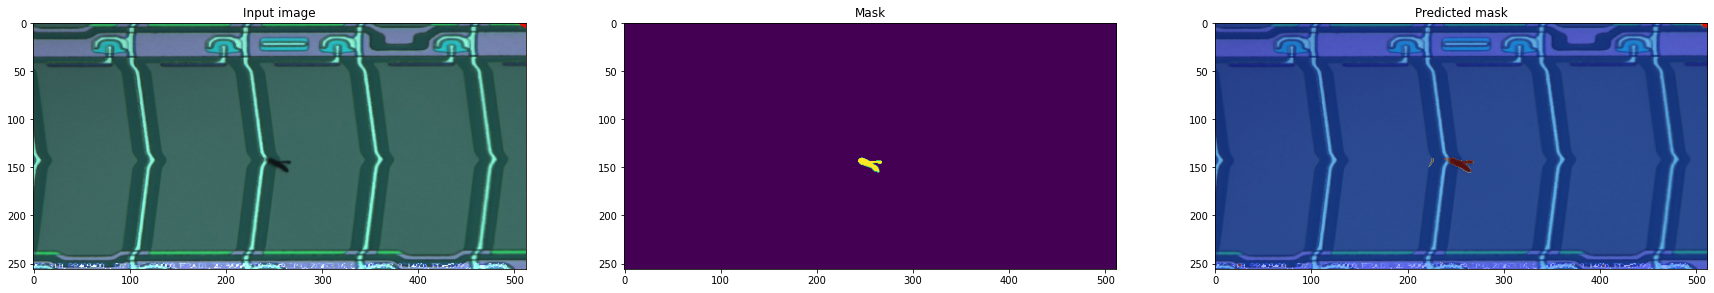

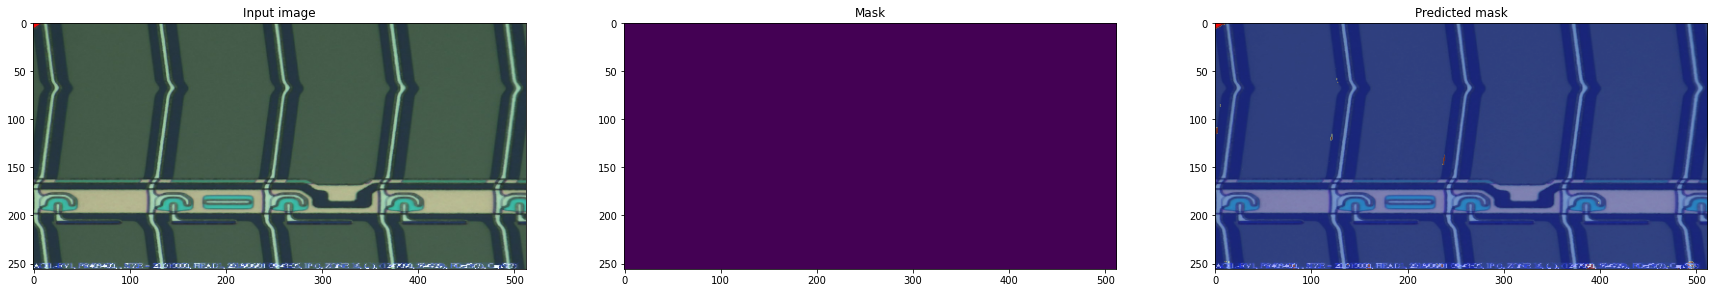

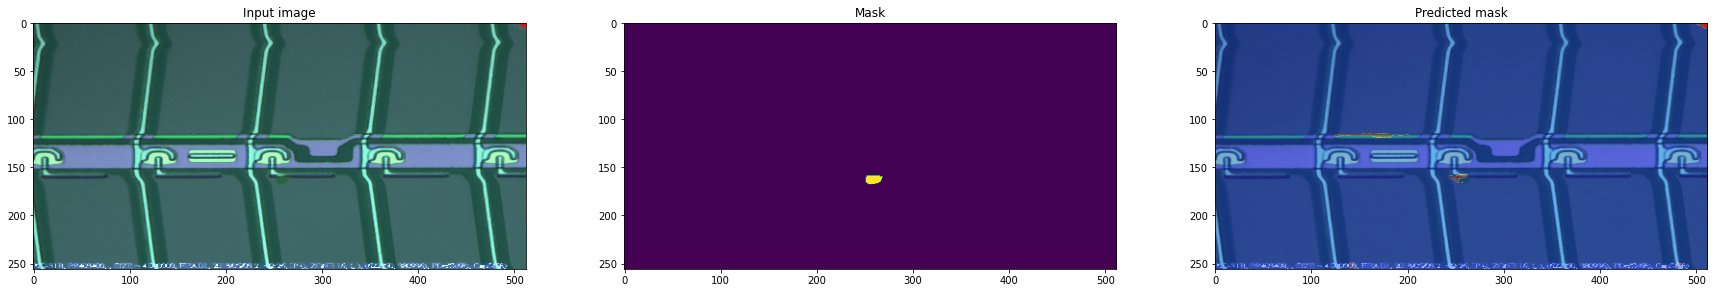

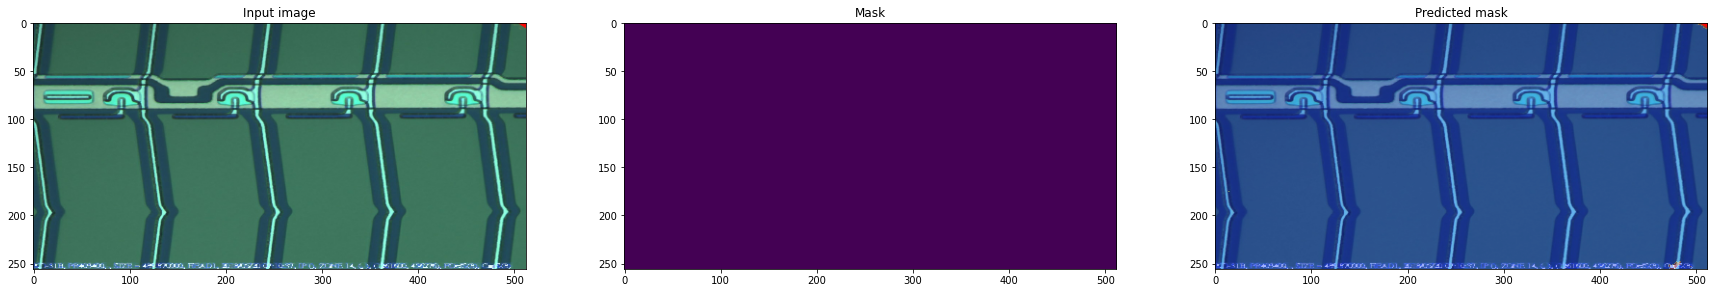

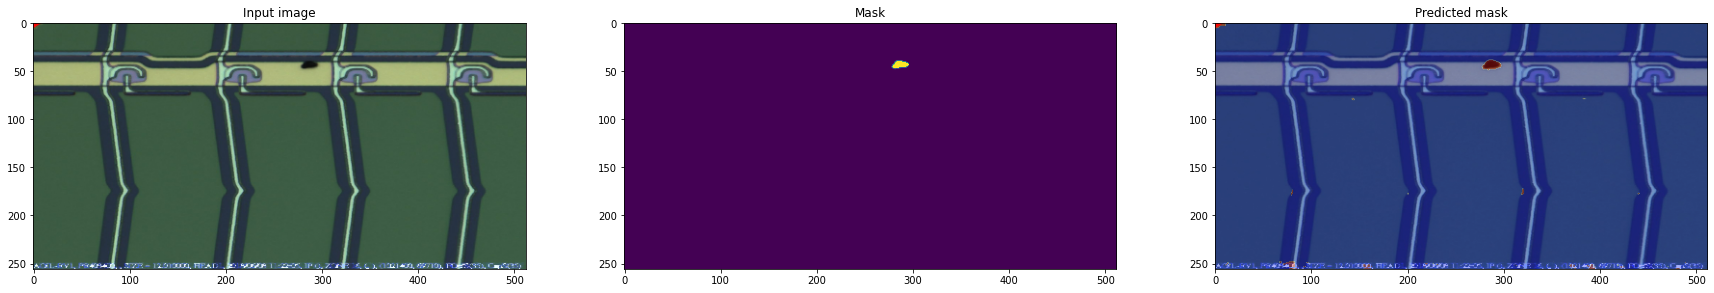

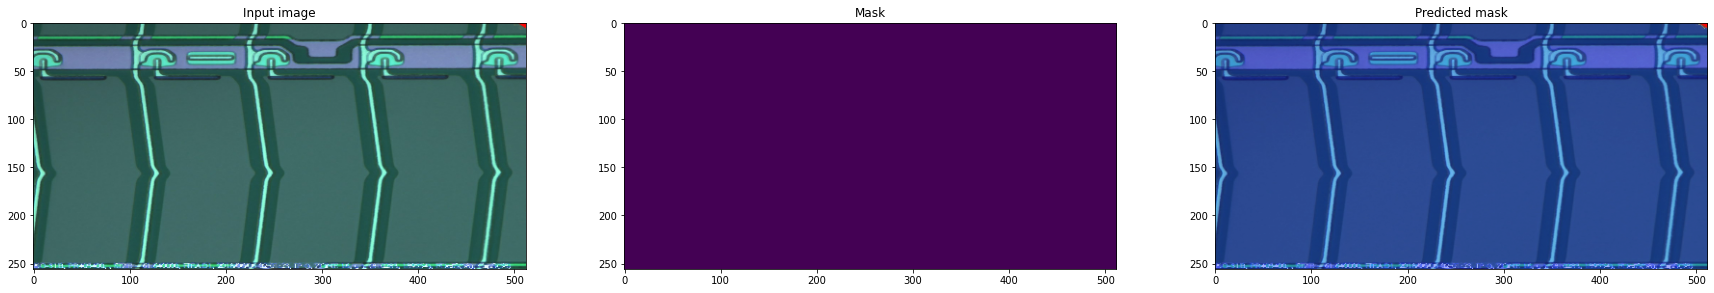

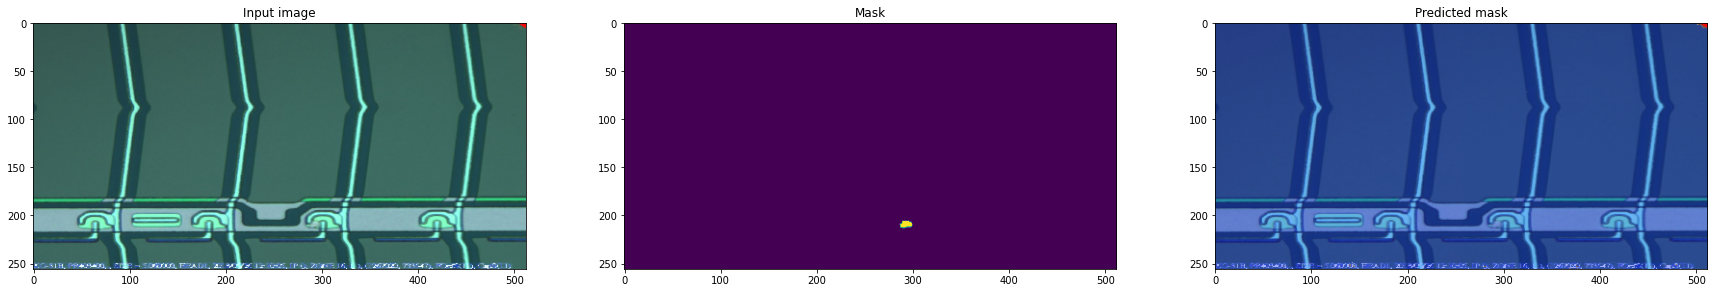

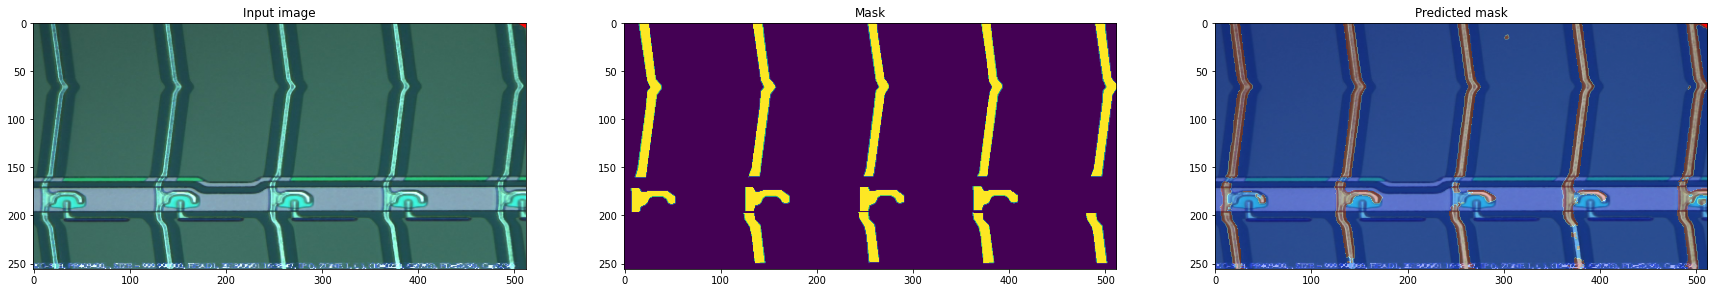

In [ ]:
title=['Input image','Mask','Predicted mask']


for image, mask, in val_dataset.take(8):

  plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(30,20))
  
  pred= model.predict(image)
 
 
  plt.subplot(1,3,1)
  plt.title(title[0])
  plt.imshow(image[0,:,:,:])


  
  plt.subplot(1,3,2)
  plt.title(title[1])
  plt.imshow(mask[0,:,:,0])

 
  plt.subplot(1,3,3)
  plt.title(title[2])
  plt.imshow(image[0,:,:,:])
  plt.imshow(pred[0,:,:,0],cmap='bwr', alpha=0.3)